In [384]:
import json

import agama
import h5py
import matplotlib.pyplot as plt
import numpy as np
from gc_utils import iteration_name  # type: ignore
from scipy.interpolate import interp1d, PchipInterpolator

In [385]:
sim = "m12i"

data_dir = "/Users/z5114326/Documents/GitHub/gc_statistics/data/"
data_file = data_dir + "m12i_time_dep.json"

sim_dir = "/Users/z5114326/Documents/simulations/"
pot_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/potentials/"

fire_dir = sim_dir + sim + "/" + sim + "_res7100/"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

agama.setUnits(mass=1, length=1, velocity=1)

with open(data_file, "r") as file:
    data_dict = json.load(file)

In [386]:
data_dict["it000"]["0"].keys()

dict_keys(['snapshot', 'time', 'lbt', 'redshift', 'density_thresh', 'contour_area_per', 'kl', 'del_lz_norm', 'del_et_norm', 'med_lz_norm_grp', 'med_et_norm_grp', 'avg_lz_norm_grp', 'avg_et_norm_grp', 'avg_vx_grp', 'avg_vy_grp', 'avg_vz_grp', 'avg_vphi_grp', 'avg_vr_grp', 'avg_r_cyl_grp', 'avg_phi_cyl_grp', 'avg_r_grp', 'avg_r_apo_grp', 'avg_r_per_grp', 'avg_ecc_grp', 'sig_vx_grp', 'sig_vy_grp', 'sig_vz_grp', 'sig_vphi_grp', 'sig_vr_grp', 'num_gc'])

In [387]:
group_lst = []
max_group_num = 10
it_min = 0
it_max = 100

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    for group_id in data_dict[it_id].keys():
        # make sure has some gcs
        if len(data_dict[it_id][group_id]["num_gc"]) > 0:
            # if more than 5 gc were accreted
            # if data_dict[it_id][group_id]["num_gc"][0] >= max_group_num:
            # if more than 5 gc remain at last snap
            if data_dict[it_id][group_id]["num_gc"][-1] >= max_group_num:
                group_lst.append(group_id)

group_lst = list(set(group_lst))
print(group_lst)  # Order may change

['16199669', '8580896', '1920378', '3159643', '0', '13687078', '4414957', '19898495']


In [388]:
prop_dict = {}
for prop in list(data_dict["it000"]["0"].keys())[4:]:
    #     print(prop)

    prop_dict[prop] = {}

    for group_id in group_lst:
        prop_dict[prop][group_id] = {}

        # Collect all unique time stamps across iterations
        time_set = set()

        for it in range(it_min, it_max + 1):
            it_id = iteration_name(it)
            if group_id in data_dict[it_id]:  # Ensure the group_id exists in this iteration
                time_set.update(data_dict[it_id][group_id]["time"])

        # Convert to sorted list
        time_lst = sorted(time_set)
        prop_dict[prop][group_id]["time"] = time_lst

        # Dictionary to store property values for each time
        time_dict = {t: [] for t in time_lst}

        for it in range(it_min, it_max + 1):
            it_id = iteration_name(it)
            if group_id in data_dict[it_id]:  # Ensure the group_id exists in this iteration
                for time_stamp in time_lst:
                    # Find indices where time matches
                    idx_lst = np.where(np.array(data_dict[it_id][group_id]["time"]) == time_stamp)[0]
                    if len(idx_lst) > 0:
                        idx = idx_lst[0]
                        prop_val = data_dict[it_id][group_id][prop][idx]
                        if prop_val == "NA":
                            prop_val = np.nan

                        if not np.isnan(prop_val):
                            time_dict[time_stamp].append(prop_val)  # Collect values for averaging

        # Compute the average for each time stamp
        prop_avg_lst = [np.nanmean(time_dict[t]) if time_dict[t] else np.nan for t in time_lst]
        prop_std_lst = [np.nanstd(time_dict[t]) if time_dict[t] else np.nan for t in time_lst]

        prop_dict[prop][group_id]["time_avg"] = prop_avg_lst
        prop_dict[prop][group_id]["time_std"] = prop_std_lst

In [389]:
prop_dict.keys()

dict_keys(['density_thresh', 'contour_area_per', 'kl', 'del_lz_norm', 'del_et_norm', 'med_lz_norm_grp', 'med_et_norm_grp', 'avg_lz_norm_grp', 'avg_et_norm_grp', 'avg_vx_grp', 'avg_vy_grp', 'avg_vz_grp', 'avg_vphi_grp', 'avg_vr_grp', 'avg_r_cyl_grp', 'avg_phi_cyl_grp', 'avg_r_grp', 'avg_r_apo_grp', 'avg_r_per_grp', 'avg_ecc_grp', 'sig_vx_grp', 'sig_vy_grp', 'sig_vz_grp', 'sig_vphi_grp', 'sig_vr_grp', 'num_gc'])

In [390]:
# get colours for groups

num_groups = len(group_lst)
cmap = plt.get_cmap("tab20b")
colors = [cmap(i / (num_groups - 1) if num_groups > 1 else 0.5) for i in range(num_groups)]

# Create a dictionary mapping group_id to color
group_colors = {group_id: colors[i] for i, group_id in enumerate(group_lst)}

In [391]:
group_lst

['16199669',
 '8580896',
 '1920378',
 '3159643',
 '0',
 '13687078',
 '4414957',
 '19898495']

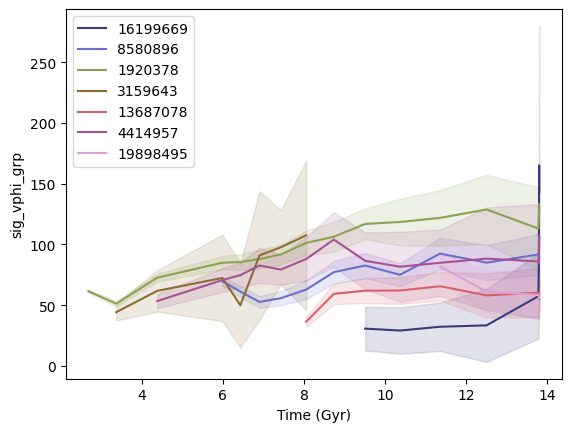

In [392]:
prop = "sig_vphi_grp"

for group_id in group_lst:
    if group_id == "0":
        continue

    color = group_colors[group_id]

    x = prop_dict[prop][group_id]["time"]
    y = prop_dict[prop][group_id]["time_avg"]
    y_err = prop_dict[prop][group_id]["time_std"]

    plt.plot(x, y, c=color, label=group_id)

    plt.fill_between(x, np.array(y) - np.array(y_err), np.array(y) + np.array(y_err), color=color, alpha=0.15)

    plt.xlabel("Time (Gyr)")
    plt.ylabel(prop)

plt.legend()

Make GC destruction mass function

In [393]:
proc_data["it000"]["source"].keys()

<KeysViewHDF5 ['accretion_flag', 'analyse_flag', 'feh', 'form_lbt', 'form_time', 'gc_id', 'group_id', 'halo_acc_cid', 'halo_acc_tid', 'halo_pre_acc_cid', 'halo_pre_acc_tid', 'halo_z0', 'halo_zform', 'is_mpb', 'last_snap', 'logm_tform', 'logm_z0', 'ptype', 'pubsnap_zform', 'quality', 'real_flag', 'snap_acc', 'snap_pre_acc', 'snap_zform', 'survive_flag', 'survived_accretion', 't_acc', 't_dis', 'zform']>

(0.0, 1.0)

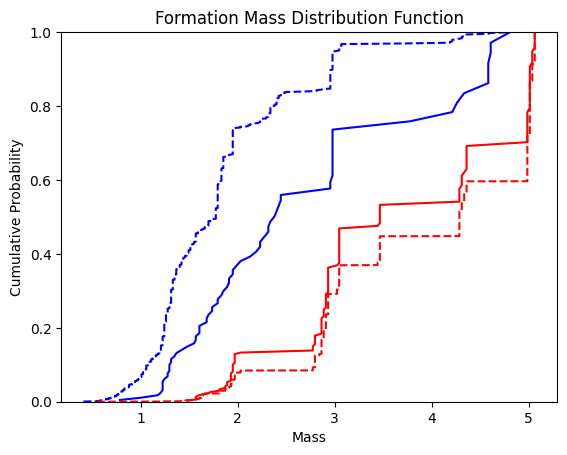

In [394]:
prop = "form_time"

# for it in range(it_min, it_max + 1):
for it in range(0, 1):
    it_id = iteration_name(it)

    src_data = proc_data[it_id]["source"]

    ana_mask = np.array(src_data["analyse_flag"]) == 1
    acc_mask = np.array(src_data["accretion_flag"]) == 1
    sacc_mask = np.array(src_data["survived_accretion"]) == 1
    dis_mask = np.array(src_data["t_dis"]) != -1

    # ex-situ ********************************************

    mass_dead_acc = src_data[prop][ana_mask & acc_mask & sacc_mask & dis_mask]
    sorted_mass_dead_acc = np.sort(mass_dead_acc)
    # sorted_mass_dead_acc = 10**sorted_mass_dead_acc

    mass_surv_acc = src_data[prop][ana_mask & acc_mask & sacc_mask & ~dis_mask]
    sorted_mass_surv_acc = np.sort(mass_surv_acc)
    # sorted_mass_surv_acc = 10**sorted_mass_surv_acc

    # in-situ ********************************************

    mass_dead_in = src_data[prop][ana_mask & ~acc_mask & dis_mask]
    sorted_mass_dead_in = np.sort(mass_dead_in)
    # sorted_mass_dead_in = 10**sorted_mass_dead_in

    mass_surv_in = src_data[prop][ana_mask & ~acc_mask & ~dis_mask]
    sorted_mass_surv_in = np.sort(mass_surv_in)
    # sorted_mass_surv_in = 10**sorted_mass_surv_in

    # Calculate the cumulative sum
    cdf_dead_acc = np.cumsum(sorted_mass_dead_acc) / np.sum(sorted_mass_dead_acc)  # Normalize the CDF
    cdf_surv_acc = np.cumsum(sorted_mass_surv_acc) / np.sum(sorted_mass_surv_acc)  # Normalize the CDF

    cdf_dead_in = np.cumsum(sorted_mass_dead_in) / np.sum(sorted_mass_dead_in)  # Normalize the CDF
    cdf_surv_in = np.cumsum(sorted_mass_surv_in) / np.sum(sorted_mass_surv_in)  # Normalize the CDF

    # Plot the CDF
    plt.plot(sorted_mass_dead_acc, cdf_dead_acc, label="destroyed ex-situ", c="blue", ls="--")
    plt.plot(sorted_mass_surv_acc, cdf_surv_acc, label="survivng ex-situ", c="blue", ls="-")

    plt.plot(sorted_mass_dead_in, cdf_dead_in, label="destroyed in-situ", c="red", ls="--")
    plt.plot(sorted_mass_surv_in, cdf_surv_in, label="survivng in-situ", c="red", ls="-")


plt.xlabel("Mass")
plt.ylabel("Cumulative Probability")
plt.title("Formation Mass Distribution Function")
# plt.xscale("log")
# plt.xlim(5 * 10**3, 10**7)
plt.ylim(0, 1)
# plt.legend(loc="upper left")

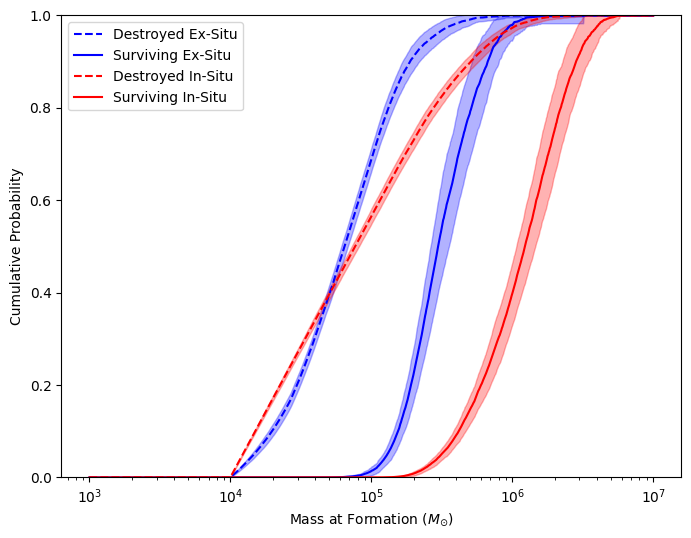

In [395]:
# Define common mass grid
prop = "logm_tform"
common_grid = np.logspace(3, 7, 1000)  # Ensure logarithmic spacing

# Lists to store interpolated CDFs
cdf_dead_acc_list = []
cdf_surv_acc_list = []
cdf_dead_in_list = []
cdf_surv_in_list = []

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    src_data = proc_data[it_id]["source"]

    ana_mask = np.array(src_data["analyse_flag"]) == 1
    acc_mask = np.array(src_data["accretion_flag"]) == 1
    sacc_mask = np.array(src_data["survived_accretion"]) == 1
    dis_mask = np.array(src_data["t_dis"]) != -1

    # Extract masses and convert from log-space
    mass_dead_acc = 10 ** np.sort(src_data[prop][ana_mask & acc_mask & sacc_mask & dis_mask])
    mass_surv_acc = 10 ** np.sort(src_data[prop][ana_mask & acc_mask & sacc_mask & ~dis_mask])
    mass_dead_in = 10 ** np.sort(src_data[prop][ana_mask & ~acc_mask & dis_mask])
    mass_surv_in = 10 ** np.sort(src_data[prop][ana_mask & ~acc_mask & ~dis_mask])

    def get_mass_cdf(mass_arr):
        return np.cumsum(mass_arr) / np.sum(mass_arr)

    def safe_interpolate(x, y, mass_grid):
        interp_func = interp1d(x, y, kind="previous", bounds_error=False, fill_value=(0, 1))
        return interp_func(mass_grid)

    # Compute CDFs
    cdf_dead_acc_list.append(safe_interpolate(mass_dead_acc, get_mass_cdf(mass_dead_acc), common_grid))
    cdf_surv_acc_list.append(safe_interpolate(mass_surv_acc, get_mass_cdf(mass_surv_acc), common_grid))
    cdf_dead_in_list.append(safe_interpolate(mass_dead_in, get_mass_cdf(mass_dead_in), common_grid))
    cdf_surv_in_list.append(safe_interpolate(mass_surv_in, get_mass_cdf(mass_surv_in), common_grid))

# Convert lists to arrays
cdf_dead_acc_arr = np.array(cdf_dead_acc_list)
cdf_surv_acc_arr = np.array(cdf_surv_acc_list)
cdf_dead_in_arr = np.array(cdf_dead_in_list)
cdf_surv_in_arr = np.array(cdf_surv_in_list)

# Compute mean and standard deviation
mean_cdf_dead_acc = np.mean(cdf_dead_acc_arr, axis=0)
std_cdf_dead_acc = np.std(cdf_dead_acc_arr, axis=0)

mean_cdf_surv_acc = np.mean(cdf_surv_acc_arr, axis=0)
std_cdf_surv_acc = np.std(cdf_surv_acc_arr, axis=0)

mean_cdf_dead_in = np.mean(cdf_dead_in_arr, axis=0)
std_cdf_dead_in = np.std(cdf_dead_in_arr, axis=0)

mean_cdf_surv_in = np.mean(cdf_surv_in_arr, axis=0)
std_cdf_surv_in = np.std(cdf_surv_in_arr, axis=0)

# Plot mean CDF with error regions
plt.figure(figsize=(8, 6))

plt.plot(common_grid, mean_cdf_dead_acc, label="Destroyed Ex-Situ", c="blue", ls="--")
plt.fill_between(
    common_grid,
    mean_cdf_dead_acc - std_cdf_dead_acc,
    mean_cdf_dead_acc + std_cdf_dead_acc,
    color="blue",
    alpha=0.3,
)

plt.plot(common_grid, mean_cdf_surv_acc, label="Surviving Ex-Situ", c="blue", ls="-")
plt.fill_between(
    common_grid,
    mean_cdf_surv_acc - std_cdf_surv_acc,
    mean_cdf_surv_acc + std_cdf_surv_acc,
    color="blue",
    alpha=0.3,
)

plt.plot(common_grid, mean_cdf_dead_in, label="Destroyed In-Situ", c="red", ls="--")
plt.fill_between(
    common_grid,
    mean_cdf_dead_in - std_cdf_dead_in,
    mean_cdf_dead_in + std_cdf_dead_in,
    color="red",
    alpha=0.3,
)

plt.plot(common_grid, mean_cdf_surv_in, label="Surviving In-Situ", c="red", ls="-")
plt.fill_between(
    common_grid,
    mean_cdf_surv_in - std_cdf_surv_in,
    mean_cdf_surv_in + std_cdf_surv_in,
    color="red",
    alpha=0.3,
)

plt.xscale("log")
plt.xlabel(r"Mass at Formation ($M_{\odot}$)")
plt.ylabel("Cumulative Probability")
# plt.title("GC Mass at Formation")
plt.ylim(0, 1)
plt.legend()
plt.show()


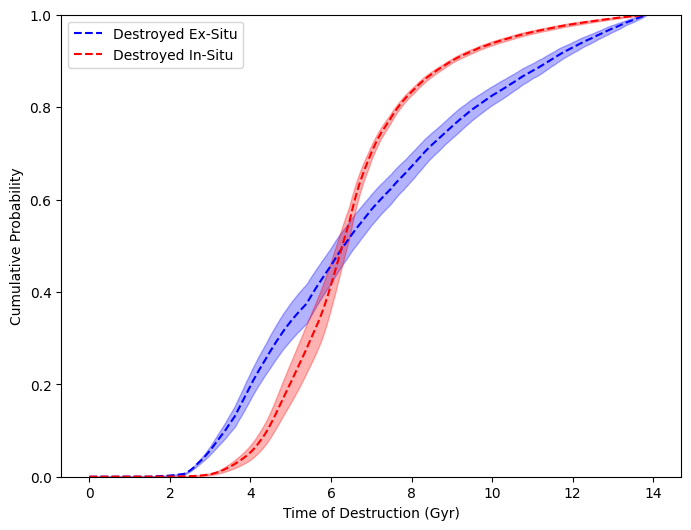

In [396]:
# Define common mass grid
prop = "t_dis"
common_grid = np.linspace(0, 14, 1000)

# Lists to store interpolated CDFs
cdf_dead_acc_list = []
cdf_surv_acc_list = []
cdf_dead_in_list = []
cdf_surv_in_list = []

for it in range(it_min, it_max + 1):
    # for it in range(0, 1):
    it_id = iteration_name(it)
    src_data = proc_data[it_id]["source"]

    ana_mask = np.array(src_data["analyse_flag"]) == 1
    acc_mask = np.array(src_data["accretion_flag"]) == 1
    sacc_mask = np.array(src_data["survived_accretion"]) == 1
    dis_mask = np.array(src_data["t_dis"]) != -1

    # Extract masses and convert from log-space
    mass_dead_acc = np.sort(src_data[prop][ana_mask & acc_mask & sacc_mask & dis_mask])
    mass_surv_acc = np.sort(src_data[prop][ana_mask & acc_mask & sacc_mask & ~dis_mask])
    mass_dead_in = np.sort(src_data[prop][ana_mask & ~acc_mask & dis_mask])
    mass_surv_in = np.sort(src_data[prop][ana_mask & ~acc_mask & ~dis_mask])

    def get_mass_cdf(mass_arr):
        return np.cumsum(mass_arr) / np.sum(mass_arr)

    def safe_interpolate(x, y, mass_grid):
        interp_func = interp1d(x, y, kind="previous", bounds_error=False, fill_value=(0, 1))
        return interp_func(mass_grid)

    # Compute CDFs
    cdf_dead_acc_list.append(safe_interpolate(mass_dead_acc, get_mass_cdf(mass_dead_acc), common_grid))
    cdf_surv_acc_list.append(safe_interpolate(mass_surv_acc, get_mass_cdf(mass_surv_acc), common_grid))
    cdf_dead_in_list.append(safe_interpolate(mass_dead_in, get_mass_cdf(mass_dead_in), common_grid))
    cdf_surv_in_list.append(safe_interpolate(mass_surv_in, get_mass_cdf(mass_surv_in), common_grid))

# Convert lists to arrays
cdf_dead_acc_arr = np.array(cdf_dead_acc_list)
cdf_surv_acc_arr = np.array(cdf_surv_acc_list)
cdf_dead_in_arr = np.array(cdf_dead_in_list)
cdf_surv_in_arr = np.array(cdf_surv_in_list)

# Compute mean and standard deviation
mean_cdf_dead_acc = np.mean(cdf_dead_acc_arr, axis=0)
std_cdf_dead_acc = np.std(cdf_dead_acc_arr, axis=0)

mean_cdf_surv_acc = np.mean(cdf_surv_acc_arr, axis=0)
std_cdf_surv_acc = np.std(cdf_surv_acc_arr, axis=0)

mean_cdf_dead_in = np.mean(cdf_dead_in_arr, axis=0)
std_cdf_dead_in = np.std(cdf_dead_in_arr, axis=0)

mean_cdf_surv_in = np.mean(cdf_surv_in_arr, axis=0)
std_cdf_surv_in = np.std(cdf_surv_in_arr, axis=0)

# Plot mean CDF with error regions
plt.figure(figsize=(8, 6))

plt.plot(common_grid, mean_cdf_dead_acc, label="Destroyed Ex-Situ", c="blue", ls="--")
plt.fill_between(
    common_grid,
    mean_cdf_dead_acc - std_cdf_dead_acc,
    mean_cdf_dead_acc + std_cdf_dead_acc,
    color="blue",
    alpha=0.3,
)

# plt.plot(common_grid, mean_cdf_surv_acc, label="Surviving Ex-Situ", c="blue", ls="-")
# plt.fill_between(
#     common_grid,
#     mean_cdf_surv_acc - std_cdf_surv_acc,
#     mean_cdf_surv_acc + std_cdf_surv_acc,
#     color="blue",
#     alpha=0.3,
# )

plt.plot(common_grid, mean_cdf_dead_in, label="Destroyed In-Situ", c="red", ls="--")
plt.fill_between(
    common_grid,
    mean_cdf_dead_in - std_cdf_dead_in,
    mean_cdf_dead_in + std_cdf_dead_in,
    color="red",
    alpha=0.3,
)

# plt.plot(common_grid, mean_cdf_surv_in, label="Surviving In-Situ", c="red", ls="-")
# plt.fill_between(
#     common_grid,
#     mean_cdf_surv_in - std_cdf_surv_in,
#     mean_cdf_surv_in + std_cdf_surv_in,
#     color="red",
#     alpha=0.3,
# )

# plt.xscale("log")
plt.xlabel("Time of Destruction (Gyr)")
plt.ylabel("Cumulative Probability")
# plt.title("GC Mass at Formation")
# plt.xlim(0, 6)
plt.ylim(0, 1)
plt.legend()
plt.show()


In [397]:
proc_data.close()